# Generar piezas musicales con el dataset de Spanio 🎵

Utilizar los pesos de music_audioset_epoch_15_esc_90.14.pt en lugar de los genéricos que carga clap_model.load_ckpt() para verificar si hay una mejoría en el CLAP Score.


In [18]:
import os
import pandas as pd
import numpy as np
import json
import random
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchaudio
from laion_clap import CLAP_Module
from torch import serialization
from tqdm import tqdm

import laion_clap.clap_module.factory as factory
import laion_clap.hook as hook

In [2]:
import sys
from pathlib import Path

# Detectar la raíz del proyecto automáticamente
PROJECT_ROOT = Path.cwd()
for parent in [PROJECT_ROOT, *PROJECT_ROOT.parents]:
    if (parent / "models" / "scripts" / "types.py").exists():
        PROJECT_ROOT = parent
        break

# Agregar la raíz al sys.path si no está
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

print("🔍 Raíz del proyecto:", PROJECT_ROOT)

🔍 Raíz del proyecto: /home/juana/audio_reprompt


In [3]:
from models.scripts.types import MusicGenCLAPResult, MusicGenData
from config import load_config, setup_project_paths, PROJECT_ROOT

In [4]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Dispositivo: {DEVICE}")

Dispositivo: cpu


In [5]:
print("Configurando las rutas del proyecto...")
setup_project_paths()

print("Cargando configuración...")
config = load_config()

Configurando las rutas del proyecto...
Cargando configuración...


In [19]:
tracks_base_data_path = PROJECT_ROOT / config.data.tracks_base_data_path
data_clap_path = (
    PROJECT_ROOT / config.data.data_clap_path / "results_with_clap_weights.csv"
)

laion_clap_path = PROJECT_ROOT / config.model.laion_clap_path

embeddings_csv_path = (
    PROJECT_ROOT / config.data.embeddings_csv_path / "embeddings_different_weights.csv"
)

embeddings_patched_csv_path = (
    PROJECT_ROOT
    / config.data.embeddings_csv_path
    / "embeddings_different_weights_patched.csv"
)

embeddings_base_csv_path = (
    PROJECT_ROOT / config.data.embeddings_csv_path / "music_base_prompts_embeddings.csv"
)

### Fijar semilla reproducción


In [7]:
def set_reproducibility(seed: int = 42):
    """
    Fija todas las semillas y configuraciones necesarias para que
    los resultados (embeddings, scores, etc.) sean reproducibles en CLAP o PyTorch.
    """
    print(f"Estableciendo modo determinista con semilla {seed}")

    # Python
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Modo determinista completo (puede afectar rendimiento, pero asegura reproducibilidad)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(True, warn_only=True)

    print("Semillas y modo determinista configurados.\n")

### Calcular el CLAP Score


`CLAP_Module`:

Es un wrapper del modelo CLAP que permite el uso del modelo CLAP para obtener embeddings de audio y texto, calcular similitudes o entrenar nuevos modelos multimodales.

Parámetro:

- `enable_fusion`: activa o desactiva un mecanismo interno del modelo CLAP que combina información de audio y texto en una representación conjunta, es decir, un embedding fusionado. Esto permite calcular de forma directa una similitud entre embeddings audio ↔ texto, sin necesidad de entrenar un modelo adicional. Si es False, el modelo cargaría solo el codificador de audio o texto, sin capacidad de comparar entre ellos, por lo que el cálculo de similitud coseno no tendría sentido.

Fórmula de la similitud del coseno:

$$
\text{sim}(a, b) = \frac{a \cdot b}{\|a\| \|b\|}
$$

El resultado (score) es un número entre -1 y 1:

- +1 → audio y texto son muy similares.

- 0 → no hay relación.

- -1 → son opuestos semánticamente (raro en práctica).

¿Por qué en CLAP casi nunca salen negativos?

El modelo CLAP fue entrenado con una pérdida contrastiva tipo InfoNCE que:

- Maximiza la similitud entre los pares correctos (audio ↔ descripción)
- Minimiza la similitud entre los pares incorrectos.

El modelo nunca vio ejemplos de “oposición semántica” (como “silencio” vs “explosión”) durante el entrenamiento, por eso, el coseno rara vez llega a valores extremos (−1 o 1).

Por lo tanto, tras el entrenamiento:

| Tipo de relación audio-texto | CLAP Score típico |
| ---------------------------- | ----------------- |
| Muy alta coherencia          | 0.7 – 0.9         |
| Moderada coherencia          | 0.4 – 0.6         |
| Poca coherencia              | 0.2 – 0.4         |
| Ruido o sin relación         | < 0.2             |

[Ver referencia de clap score](https://arxiv.org/html/2506.23553v2)


#### Funciones para utilizar otros pesos con Clap Score

El modelo CLAP (Contrastive Language-Audio Pretraining) tiene múltiples variantes entrenadas en distintos datasets:

| Alias            | Modelo base real    | Dataset                 | Uso principal            |
| ---------------- | ------------------- | ----------------------- | ------------------------ |
| `music_audioset` | `HTSAT-base`        | AudioSet + ESC-50       | Música y sonidos         |
| `HTSAT-base`     | Transformer HTSAT   | Audio feature extractor | Base de “music_audioset” |
| `roberta-base`   | Transformer textual | Text encoder            | Texto de prompts         |

El checkpoint music_audioset_epoch_15_esc_90.14.pt fue entrenado sobre la arquitectura HTSAT-base (audio encoder) + roberta-base (text encoder), pero el código original del paquete laion_clap no reconoce “music_audioset” como un nombre de modelo válido.

¿Por qué no poner directamente HTSAT-base?

Porque el nombre music_audioset no es solo un alias cosmético, sino que está ligado al tipo de checkpoint y la arquitectura que CLAP espera internamente.

- HTSAT-base es un modelo de audio genérico.

- music_audioset es una versión fine-tuned (ajustada) de HTSAT-base + text encoder (RoBERTa) sobre el dataset AudioSet + ESC-50.


### Patched Weights


In [8]:
def patched_create_model(amodel_name: str, *args, **kwargs):
    """
    Intercepta la llamada que crea el modelo y reemplaza el identificador "music_audioset" por
    "HTSAT-base" antes de que el código interno lo procese.
    """
    if amodel_name == "music_audioset":
        print("🎵 Usando modelo 'music_audioset' (alias de HTSAT-base)")
        amodel_name = "HTSAT-base"
    return (
        factory._create_model(amodel_name, *args, **kwargs)
        if hasattr(factory, "_create_model")
        else factory.create_model(amodel_name, *args, **kwargs)
    )


# Guardar referencia al original.
factory._create_model = getattr(factory, "create_model", None)

# Reemplazar en ambos lugares.
factory.create_model = patched_create_model
hook.create_model = patched_create_model

print(
    "Parche aplicado: CLAP_Module ahora reconoce 'music_audioset' como alias de 'HTSAT-base'"
)


def patched_load_state_dict(checkpoint_path, map_location="cpu"):
    """
    Modifica cómo se cargan los pesos (state_dict) del checkpoint.

    Patches factory.load_state_dict:
    1. Resuelve el error de seguridad (numpy global).
    2. Asegura que NO se salten los parámetros ('skip_params=False' implícito)
       para que se carguen los pesos de audio (HTSAT) y texto (RoBERTa).
    """

    # Define los globals requeridos por el checkpoint.
    safe_globals = ["numpy.core.multiarray.scalar"]

    print(
        f"✅ Aplicando parche de seguridad para cargar el checkpoint: {checkpoint_path}"
    )

    # 1. Usar el context manager para permitir los globals.
    # 2. Usar weights_only=False, como sugiere el error de PyTorch.
    with serialization.safe_globals(safe_globals):
        # Cargar el archivo de checkpoint completo.
        checkpoint = torch.load(
            checkpoint_path, map_location=map_location, weights_only=False
        )

    # Extraer el 'state_dict'. La mayoría de los checkpoints de PyTorch guardan los pesos aquí.
    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        # Si el checkpoint es solo el state_dict.
        state_dict = checkpoint

    return state_dict


# factory.load_state_dict = patched_load_state_dict
# print(
#    "Patch aplicado: factory.load_state_dict modificado para carga segura y completa de pesos."
# )

if not hasattr(np.random, "integers"):
    """
    Crea un alias integers → randint.
    """
    print("Aplicando parche de compatibilidad: np.random.integers -> np.random.randint")
    # Crear un alias para que las llamadas internas a 'integers' usen 'randint'.
    np.random.integers = np.random.randint

Parche aplicado: CLAP_Module ahora reconoce 'music_audioset' como alias de 'HTSAT-base'
Aplicando parche de compatibilidad: np.random.integers -> np.random.randint


In [ ]:
def compute_clap_scores_patched(
    results: list[MusicGenData],
    device=None,
    save_embeddings=True,
) -> list[MusicGenCLAPResult]:
    """
    Calcula el CLAP Score (similaridad texto-audio) usando embeddings del modelo CLAP.
    """
    set_reproducibility(42)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsando dispositivo: {device}\n")

    # 1. Cargar modelo CLAP
    clap_model = CLAP_Module(
        enable_fusion=True,
        amodel="HTSAT-base",  # Modelo de 1024 dims, compatible con el checkpoint con los pesos.
    )  # Activa la modalidad combinada audio-texto del modelo.

    state_dict = factory.load_state_dict(laion_clap_path, map_location=device)
    clap_model.model.load_state_dict(state_dict, strict=False)

    # clap_model.load_ckpt(str(laion_clap_path))  # Descarga y carga los pesos preentrenados.
    clap_model.eval()  # Modo evaluación (desactiva dropout, gradientes, etc.).
    clap_model.to(device)

    print("Modelo CLAP cargado correctamente.\nCalculando CLAP Scores...\n")

    scored: list[MusicGenCLAPResult] = []
    embedding_records = []

    # 2. Iterar sobre los resultados
    for r in tqdm(results, desc="Procesando audios", ncols=80):
        try:
            audio, sr = torchaudio.load(r.audio_path)
            if sr != 48000:
                audio = torchaudio.functional.resample(audio, sr, 48000)
            audio = audio.to(device)

            with torch.no_grad():
                audio_emb = clap_model.get_audio_embedding_from_data(
                    audio, use_tensor=True
                )
                text_emb = clap_model.get_text_embedding(
                    [r.description], use_tensor=True
                )

                audio_emb = torch.nn.functional.normalize(audio_emb, dim=-1)
                text_emb = torch.nn.functional.normalize(text_emb, dim=-1)

                score = torch.nn.functional.cosine_similarity(
                    audio_emb, text_emb
                ).item()

            audio_emb_np = audio_emb.cpu().numpy().flatten().tolist()
            text_emb_np = text_emb.cpu().numpy().flatten().tolist()

            clap_score = round(float(score), 6)
            scored.append(
                MusicGenCLAPResult(
                    id=r.id,
                    taste=r.taste,
                    description=r.description,
                    instrument=r.instrument,
                    audio_path=r.audio_path,
                    clap_score=clap_score,
                )
            )

            if save_embeddings:
                embedding_records.append(
                    {
                        "taste": r.taste,
                        "description": r.description,
                        "audio_name": r.id,
                        "clap_score": clap_score,
                        "audio_emb": json.dumps(audio_emb_np),
                        "text_emb": json.dumps(text_emb_np),
                    }
                )

        except Exception as e:
            print(f"Error procesando {r.id}: {e}")

    if save_embeddings and embedding_records:
        df = pd.DataFrame(embedding_records)
        df.to_csv(embeddings_patched_csv_path, index=False)
        print(
            f"\n Embeddings y CLAP Scores guardados en: {embeddings_patched_csv_path}\n"
        )
    return scored

In [ ]:
# 1. Construir lista de audios generados existentes.
print(f"\nBuscando audios en: {tracks_base_data_path}")
audio_files = [f for f in os.listdir(tracks_base_data_path) if f.endswith(".wav")]

if not audio_files:
    raise FileNotFoundError(f"No se encontraron audios en {tracks_base_data_path}")

print(f"Se encontraron {len(audio_files)} archivos de audio.")

# Inferir metadata a partir del nombre de archivo.
results: list[MusicGenData] = []
for fname in audio_files:
    audio_path = os.path.join(tracks_base_data_path, fname)
    file_id = os.path.splitext(fname)[0]
    taste = file_id.split("_")[0] if "_" in file_id else "unknown"
    description = f"{taste} music, ambient for fine restaurant"

    results.append(
        MusicGenData(
            id=file_id,
            taste=taste,
            instrument="N/A",
            description=description,
            audio_path=audio_path,
        )
    )

print(f"Preparados {len(results)} registros para evaluación CLAP.\n")

# 2. Calcular CLAP Scores.
scored_results = compute_clap_scores_patched(results, device=DEVICE)

# 3. Guardar resultados.
df = pd.DataFrame(scored_results)
# df.to_csv(data_clap_path, index=False)
print(f"\nPipeline completo: resultados guardados en {data_clap_path}")


Buscando audios en: /home/juana/audio_reprompt/data/tracks/generated_base_music
Se encontraron 100 archivos de audio.
Preparados 100 registros para evaluación CLAP.

Estableciendo modo determinista con semilla 42
Semillas y modo determinista configurados.


Usando dispositivo: cpu



/home/juana/.venv_pytorch25/lib64/python3.11/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo CLAP cargado correctamente.
Calculando CLAP Scores...



Procesando audios:   0%|                                | 0/100 [00:00<?, ?it/s]/home/juana/.venv_pytorch25/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
Procesando audios: 100%|██████████████████████| 100/100 [02:20<00:00,  1.40s/it]



 Embeddings y CLAP Scores guardados en: /home/juana/audio_reprompt/data/embeddings/embeddings_different_weights_patched.csv


Pipeline completo: resultados guardados en /home/juana/audio_reprompt/data/scores/results_with_clap_weights.csv


In [11]:
df

,id,instrument,taste,description,audio_path,clap_score
0,bitter_14,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.088606
1,sour_09,N/A,sour,"sour music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,0.009703
2,sweet_07,N/A,sweet,"sweet music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.105044
3,salty_16,N/A,salty,"salty music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,0.072732
4,salty_01,N/A,salty,"salty music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.099309
...,...,...,...,...,...,...
95,bitter_19,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.072987
96,bitter_16,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.058835
97,bitter_04,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.059753
98,salty_24,N/A,salty,"salty music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.088813


### Url Weights


In [15]:
def compute_clap_scores(
    results: list[MusicGenData],
    device=None,
    save_embeddings=True,
) -> list[MusicGenCLAPResult]:
    """
    Calcula el CLAP Score (similaridad texto-audio) usando embeddings del modelo CLAP.
    """
    set_reproducibility(42)
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nUsando dispositivo: {device}\n")

    # 1. Cargar modelo CLAP
    clap_model = CLAP_Module(enable_fusion=True)

    weights_url = "https://huggingface.co/lukewys/laion_clap/resolve/main/music_audioset_epoch_15_esc_90.14.pt"

    try:
        state_dict = torch.hub.load_state_dict_from_url(
            weights_url, map_location=device, weights_only=False
        )
        clap_model.load_state_dict(state_dict, strict=False)
    except Exception as e:
        clap_model.error(f"Error loading model weights from {weights_url}: {e}")
        raise

    clap_model.to(device)
    clap_model.eval()

    print("Modelo CLAP cargado correctamente.\nCalculando CLAP Scores...\n")

    scored: list[MusicGenCLAPResult] = []
    embedding_records = []

    # 2. Iterar sobre los resultados
    for r in tqdm(results, desc="Procesando audios", ncols=80):
        try:
            audio, sr = torchaudio.load(r.audio_path)
            if sr != 48000:
                audio = torchaudio.functional.resample(audio, sr, 48000)
            audio = audio.to(device)

            with torch.no_grad():
                audio_emb = clap_model.get_audio_embedding_from_data(
                    audio, use_tensor=True
                )
                text_emb = clap_model.get_text_embedding(
                    [r.description], use_tensor=True
                )

                audio_emb = torch.nn.functional.normalize(audio_emb, dim=-1)
                text_emb = torch.nn.functional.normalize(text_emb, dim=-1)

                score = torch.nn.functional.cosine_similarity(
                    audio_emb, text_emb
                ).item()

            audio_emb_np = audio_emb.cpu().numpy().flatten().tolist()
            text_emb_np = text_emb.cpu().numpy().flatten().tolist()

            clap_score = round(float(score), 6)
            scored.append(
                MusicGenCLAPResult(
                    id=r.id,
                    taste=r.taste,
                    description=r.description,
                    instrument=r.instrument,
                    audio_path=r.audio_path,
                    clap_score=clap_score,
                )
            )

            if save_embeddings:
                embedding_records.append(
                    {
                        "taste": r.taste,
                        "description": r.description,
                        "audio_name": r.id,
                        "clap_score": clap_score,
                        "audio_emb": json.dumps(audio_emb_np),
                        "text_emb": json.dumps(text_emb_np),
                    }
                )

        except Exception as e:
            print(f"Error procesando {r.id}: {e}")

    if save_embeddings and embedding_records:
        df = pd.DataFrame(embedding_records)
        df.to_csv(embeddings_csv_path, index=False)
        print(f"\n Embeddings y CLAP Scores guardados en: {embeddings_csv_path}\n")
    return scored

In [16]:
print(f"Preparados {len(results)} registros para evaluación CLAP.\n")

# 2. Calcular CLAP Scores.
scored_results = compute_clap_scores(results, device=DEVICE)

# 3. Guardar resultados.
df_weights = pd.DataFrame(scored_results)
# df.to_csv(data_clap_path, index=False)
print(f"\nPipeline completo: resultados guardados en {data_clap_path}")

Preparados 100 registros para evaluación CLAP.

Estableciendo modo determinista con semilla 42
Semillas y modo determinista configurados.


Usando dispositivo: cpu



Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelo CLAP cargado correctamente.
Calculando CLAP Scores...



Procesando audios:   0%|                                | 0/100 [00:00<?, ?it/s]/home/juana/.venv_pytorch25/lib64/python3.11/site-packages/torchaudio/transforms/_transforms.py:580: UserWarning: Argument 'onesided' has been deprecated and has no influence on the behavior of this module.
  warnings.warn(
Procesando audios: 100%|██████████████████████| 100/100 [01:29<00:00,  1.12it/s]


 Embeddings y CLAP Scores guardados en: /home/juana/audio_reprompt/data/embeddings/embeddings_different_weights.csv


Pipeline completo: resultados guardados en /home/juana/audio_reprompt/data/scores/results_with_clap_weights.csv


In [17]:
df_weights

,id,instrument,taste,description,audio_path,clap_score
0,bitter_14,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.037356
1,sour_09,N/A,sour,"sour music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.010255
2,sweet_07,N/A,sweet,"sweet music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.022236
3,salty_16,N/A,salty,"salty music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.004080
4,salty_01,N/A,salty,"salty music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.020100
...,...,...,...,...,...,...
95,bitter_19,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.016109
96,bitter_16,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.026338
97,bitter_04,N/A,bitter,"bitter music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.011066
98,salty_24,N/A,salty,"salty music, ambient for fine restaurant",/home/juana/audio_reprompt/data/tracks/generat...,-0.017188


Comparación con los clap score con los pesos por defecto:


In [20]:
df_base = pd.read_csv(embeddings_base_csv_path)
df_base

,taste,description,audio_name,clap_score,audio_emb,text_emb
0,bitter,"bitter music, ambient for fine restaurant",bitter_14,-0.096932,"[0.044822342693805695, -0.032925862818956375, ...","[0.03459259122610092, -0.1073722168803215, -0...."
1,sour,"sour music, ambient for fine restaurant",sour_09,-0.066332,"[0.004108717665076256, 0.023925943300127983, 0...","[0.0030161733739078045, -0.06056109443306923, ..."
2,sweet,"sweet music, ambient for fine restaurant",sweet_07,0.224470,"[-0.053564224392175674, -0.0005197893478907645...","[-0.0008993687224574387, -0.06469467282295227,..."
3,salty,"salty music, ambient for fine restaurant",salty_16,-0.095536,"[-0.05291870981454849, 0.014692774973809719, 0...","[-0.04431420564651489, -0.060206856578588486, ..."
4,salty,"salty music, ambient for fine restaurant",salty_01,0.073359,"[-0.050216007977724075, -0.006429882254451513,...","[-0.04431420564651489, -0.060206856578588486, ..."
...,...,...,...,...,...,...
95,bitter,"bitter music, ambient for fine restaurant",bitter_19,-0.093266,"[-0.021378373727202415, -0.018507668748497963,...","[0.03459259122610092, -0.1073722168803215, -0...."
96,bitter,"bitter music, ambient for fine restaurant",bitter_16,-0.097371,"[-0.041361186653375626, -0.0060163806192576885...","[0.03459259122610092, -0.1073722168803215, -0...."
97,bitter,"bitter music, ambient for fine restaurant",bitter_04,-0.065337,"[-0.0777268260717392, -0.0030941597651690245, ...","[0.03459259122610092, -0.1073722168803215, -0...."
98,salty,"salty music, ambient for fine restaurant",salty_24,0.022061,"[-0.07399266958236694, 0.010176927782595158, -...","[-0.04431420564651489, -0.060206856578588486, ..."


### Box Plot: Base Weights Vs Music Audioset Patched Weights


/tmp/ipykernel_10641/4219742873.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_base, x="taste", y="clap_score", ax=ax1, palette=palette)
/tmp/ipykernel_10641/4219742873.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="taste", y="clap_score", ax=ax2, palette=palette)


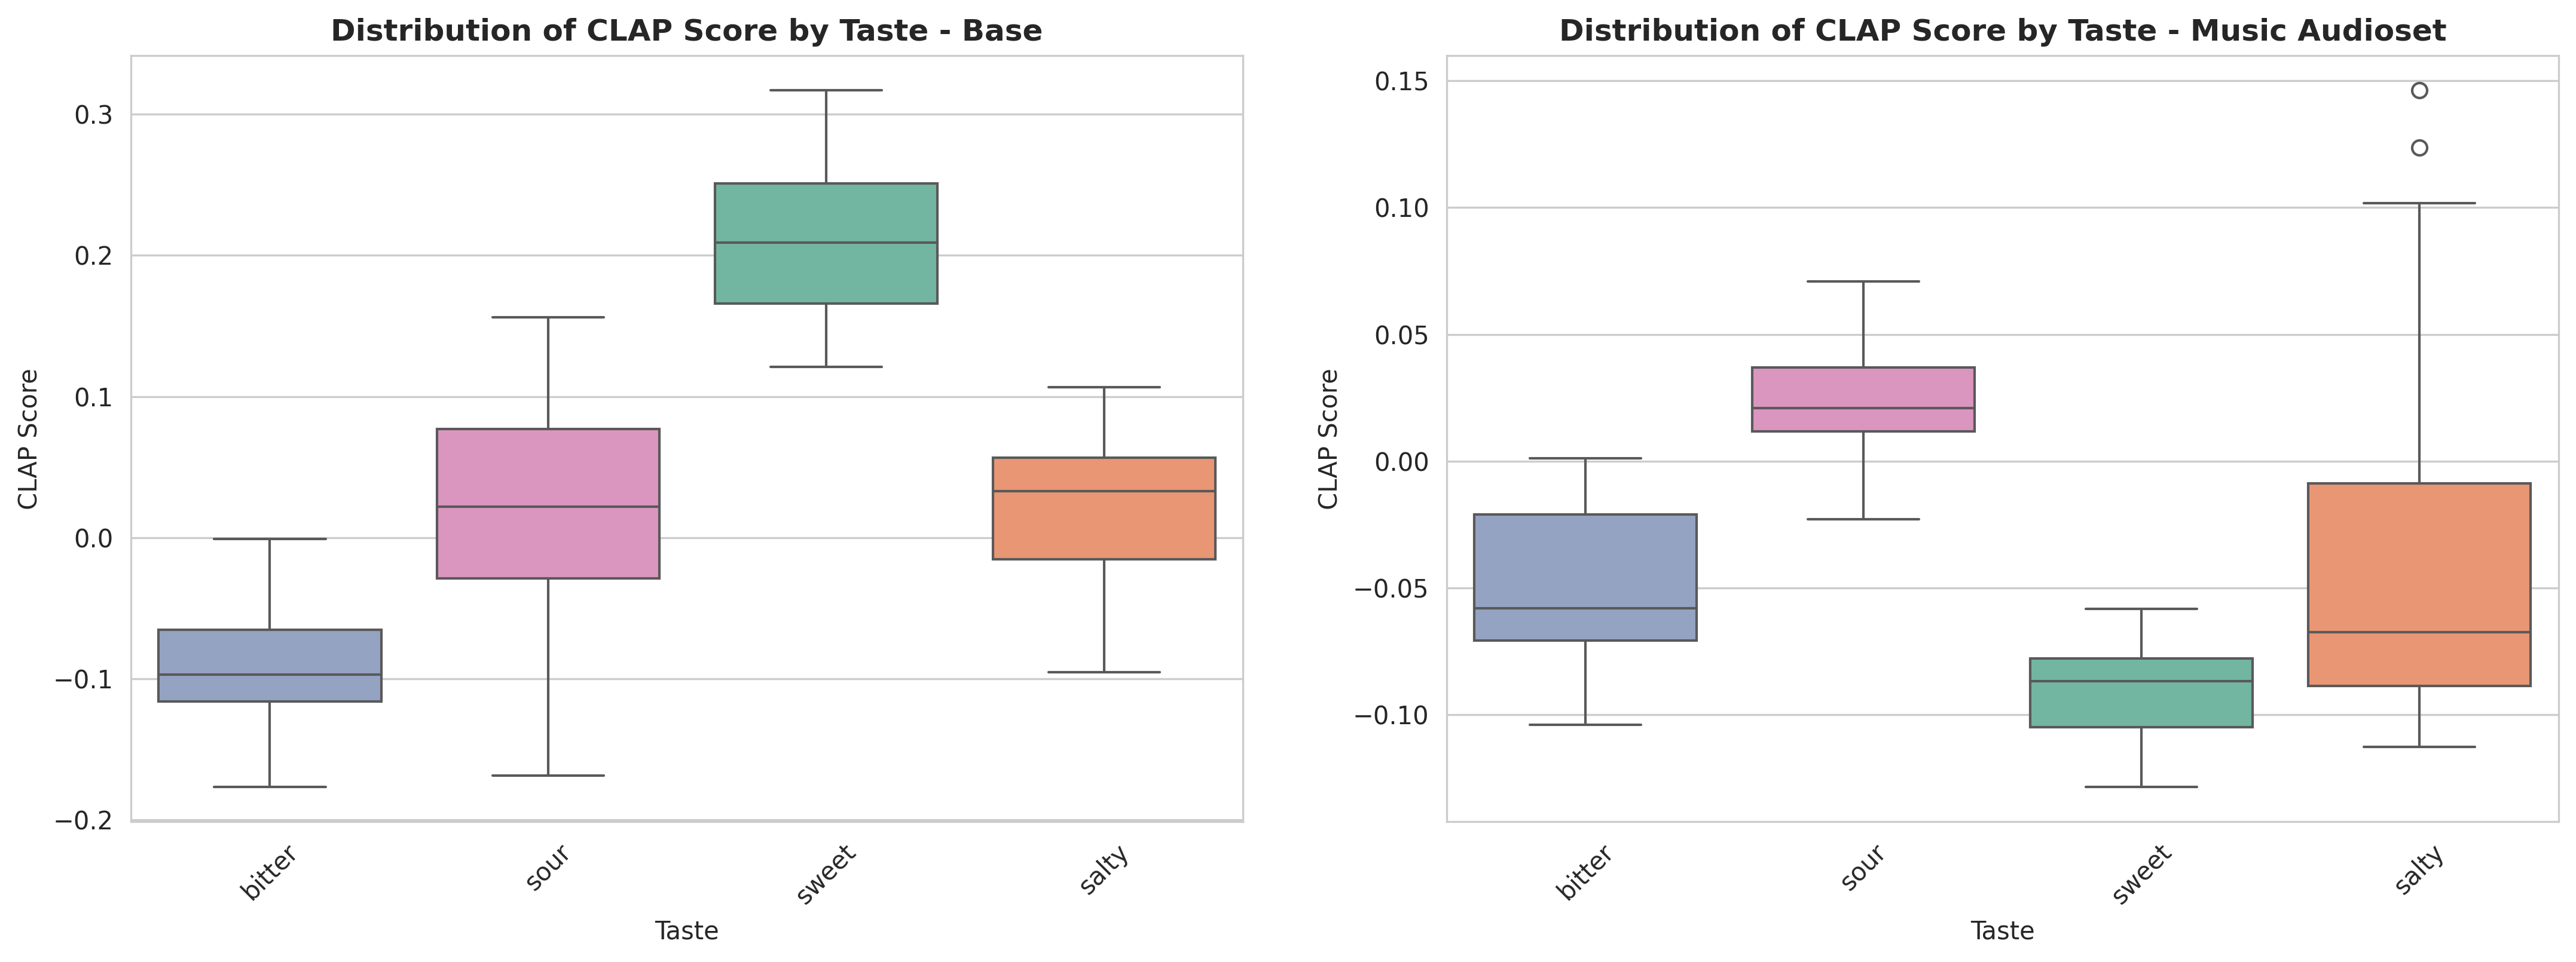

In [21]:
# Configuración de estilo para mejores visualizaciones
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 300

# Definir paleta de colores consistente para todos los sabores
palette = {
    "sweet": "#66c2a5",
    "salty": "#fc8d62",
    "bitter": "#8da0cb",
    "sour": "#e78ac3",
}

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PRIMER SUBPLOT: Base prompts
sns.boxplot(data=df_base, x="taste", y="clap_score", ax=ax1, palette=palette)
ax1.set_title("Distribution of CLAP Score by Taste - Base", fontweight="bold")
ax1.set_xlabel("Taste")
ax1.set_ylabel("CLAP Score")
ax1.tick_params(axis="x", rotation=45)

# SEGUNDO SUBPLOT: Different weights
sns.boxplot(data=df, x="taste", y="clap_score", ax=ax2, palette=palette)
ax2.set_title("Distribution of CLAP Score by Taste - Music Audioset", fontweight="bold")
ax2.set_xlabel("Taste")
ax2.set_ylabel("CLAP Score")
ax2.tick_params(axis="x", rotation=45)

# Ajustar layout y guardar
plt.tight_layout(pad=3.0)

### Box Plot: Base Weights Vs Music Audioset Weights


/tmp/ipykernel_10641/3310998483.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_base, x="taste", y="clap_score", ax=ax1, palette=palette)
/tmp/ipykernel_10641/3310998483.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_weights, x="taste", y="clap_score", ax=ax2, palette=palette)


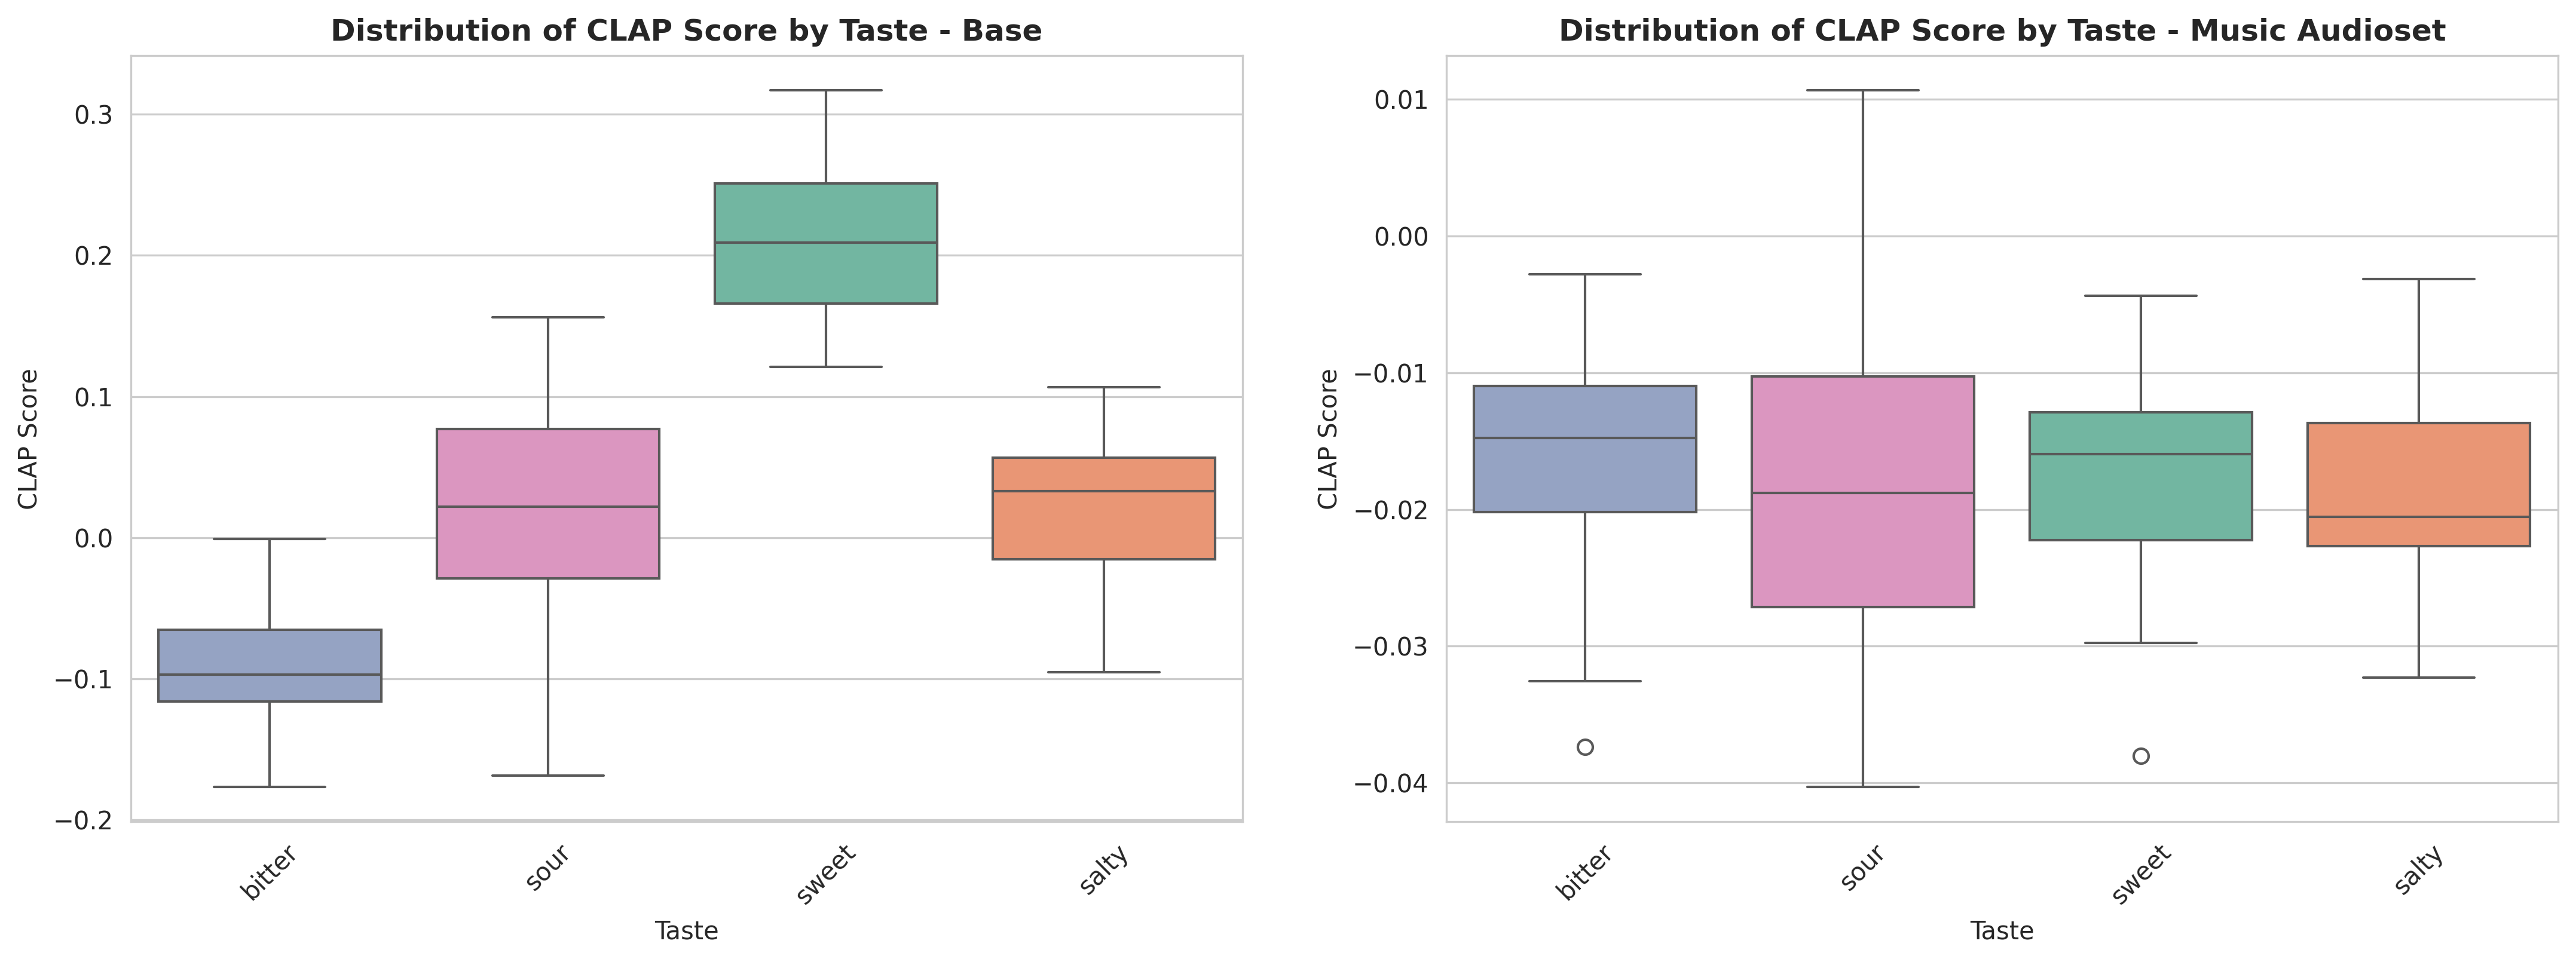

In [22]:
# Configuración de estilo para mejores visualizaciones
sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 300

# Definir paleta de colores consistente para todos los sabores
palette = {
    "sweet": "#66c2a5",
    "salty": "#fc8d62",
    "bitter": "#8da0cb",
    "sour": "#e78ac3",
}

# Crear figura con dos subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# PRIMER SUBPLOT: Base prompts
sns.boxplot(data=df_base, x="taste", y="clap_score", ax=ax1, palette=palette)
ax1.set_title("Distribution of CLAP Score by Taste - Base", fontweight="bold")
ax1.set_xlabel("Taste")
ax1.set_ylabel("CLAP Score")
ax1.tick_params(axis="x", rotation=45)

# SEGUNDO SUBPLOT: Different weights
sns.boxplot(data=df_weights, x="taste", y="clap_score", ax=ax2, palette=palette)
ax2.set_title("Distribution of CLAP Score by Taste - Music Audioset", fontweight="bold")
ax2.set_xlabel("Taste")
ax2.set_ylabel("CLAP Score")
ax2.tick_params(axis="x", rotation=45)

# Ajustar layout y guardar
plt.tight_layout(pad=3.0)

### Estadísticas


In [23]:
# Función para generar estadísticas en formato tabla
def generar_tabla_estadisticas(df, nombre_dataset):
    resultados = []

    for taste in df["taste"].unique():
        subset = df[df["taste"] == taste]["clap_score"]

        # Estadísticas descriptivas
        desc = subset.describe()
        Q1 = subset.quantile(0.25)
        Q3 = subset.quantile(0.75)
        IQR = Q3 - Q1
        lower_whisker = Q1 - 1.5 * IQR
        upper_whisker = Q3 + 1.5 * IQR
        outliers = subset[(subset < lower_whisker) | (subset > upper_whisker)].tolist()

        resultados.append(
            {
                "Dataset": nombre_dataset,
                "Taste": taste.upper(),
                "N": int(desc["count"]),
                "Mean": f"{desc['mean']:.4f}",
                "Std": f"{desc['std']:.4f}",
                "Min": f"{desc['min']:.4f}",
                "25% (Q1)": f"{Q1:.4f}",
                "Median": f"{desc['50%']:.4f}",
                "75% (Q3)": f"{Q3:.4f}",
                "Max": f"{desc['max']:.4f}",
                "IQR": f"{IQR:.4f}",
                "Lower Whisker": f"{lower_whisker:.4f}",
                "Upper Whisker": f"{upper_whisker:.4f}",
                "N Outliers": len(outliers),
                "Outliers": outliers if outliers else "None",
            }
        )

    return pd.DataFrame(resultados)

In [24]:
# Tabla para Base Prompts.
tabla_base = generar_tabla_estadisticas(df_base, "Base Prompts")
tabla_base

,Dataset,Taste,N,Mean,Std,Min,25% (Q1),Median,75% (Q3),Max,IQR,Lower Whisker,Upper Whisker,N Outliers,Outliers
0,Base Prompts,BITTER,25,-0.0951,0.0429,-0.1767,-0.1162,-0.0969,-0.0655,-0.0009,0.0507,-0.1922,0.0105,0,None
1,Base Prompts,SOUR,25,0.0191,0.0825,-0.1686,-0.0288,0.0220,0.0768,0.1561,0.1055,-0.1870,0.2350,0,None
2,Base Prompts,SWEET,25,0.2100,0.0525,0.1211,0.1660,0.2089,0.2511,0.3169,0.0851,0.0383,0.3788,0,None
3,Base Prompts,SALTY,25,0.0218,0.0517,-0.0955,-0.0153,0.0331,0.0565,0.1067,0.0717,-0.1229,0.1641,0,None


In [27]:
df_base.describe()

,clap_score
count,100.000000
mean,0.038941
std,0.124575
min,-0.176664
25%,-0.056918
50%,0.027877
75%,0.133622
max,0.316929


In [25]:
# Tabla para Music Audioset Patched.
tabla_weights = generar_tabla_estadisticas(df, "Music Audioset")
tabla_weights

,Dataset,Taste,N,Mean,Std,Min,25% (Q1),Median,75% (Q3),Max,IQR,Lower Whisker,Upper Whisker,N Outliers,Outliers
0,Music Audioset,BITTER,25,-0.0474,0.0311,-0.1040,-0.0708,-0.0580,-0.0211,0.0012,0.0497,-0.1453,0.0534,0,None
1,Music Audioset,SOUR,25,0.0243,0.0218,-0.0230,0.0117,0.0210,0.0370,0.0708,0.0253,-0.0263,0.0749,0,None
2,Music Audioset,SWEET,25,-0.0906,0.0191,-0.1285,-0.1050,-0.0869,-0.0779,-0.0584,0.0271,-0.1457,-0.0373,0,None
3,Music Audioset,SALTY,25,-0.0331,0.0782,-0.1128,-0.0888,-0.0674,-0.0088,0.1462,0.0800,-0.2088,0.1111,2,"[0.123763, 0.146234]"


In [28]:
df.describe()

,clap_score
count,100.000000
mean,-0.036705
std,0.060205
min,-0.128526
25%,-0.084061
50%,-0.059088
75%,0.009778
max,0.146234


In [26]:
# Tabla para Music Audioset.
tabla_weights = generar_tabla_estadisticas(df_weights, "Music Audioset")
tabla_weights

,Dataset,Taste,N,Mean,Std,Min,25% (Q1),Median,75% (Q3),Max,IQR,Lower Whisker,Upper Whisker,N Outliers,Outliers
0,Music Audioset,BITTER,25,-0.0163,0.0083,-0.0374,-0.0202,-0.0148,-0.0110,-0.0028,0.0092,-0.0340,0.0029,1,[-0.037356]
1,Music Audioset,SOUR,25,-0.0191,0.0121,-0.0403,-0.0271,-0.0188,-0.0103,0.0107,0.0169,-0.0524,0.0151,0,None
2,Music Audioset,SWEET,25,-0.0178,0.0073,-0.0380,-0.0222,-0.0159,-0.0129,-0.0043,0.0093,-0.0362,0.0011,1,[-0.038024]
3,Music Audioset,SALTY,25,-0.0192,0.0072,-0.0323,-0.0227,-0.0206,-0.0137,-0.0032,0.0090,-0.0361,-0.0002,0,None


In [29]:
df_weights.describe()

,clap_score
count,100.000000
mean,-0.018079
std,0.008884
min,-0.040292
25%,-0.023824
50%,-0.017986
75%,-0.011828
max,0.010651
